In [16]:
import os
import numpy as np

In [17]:
import mlflow

mlflow.sklearn.autolog()

# Create dataset

In [18]:
LABELS = ['Cassava', 'Rice', 'Maize', 'Sugarcane']

In [19]:
ROOT_DIR = os.path.abspath('..')
PROCESSED_DIR = os.path.join(ROOT_DIR, 'data', 'processed')

data_files = []

for feature_name in ['ndvi', 'ndwi', 'msavi']:
    for file in os.listdir(os.path.join(PROCESSED_DIR, feature_name)):
        if file != '.DS_Store':
            data_files.append('/'.join([PROCESSED_DIR, feature_name, file]))

data_files

['/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndvi/ndvi_feature_2D_20211222.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndvi/ndvi_feature_2D_20211127.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndvi/ndvi_feature_2D_20210620.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndvi/ndvi_feature_2D_20210327.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndwi/ndwi_feature_2D_20211127.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndwi/ndwi_feature_2D_20211222.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndwi/ndwi_feature_2D_20210327.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/ndwi/ndwi_feature_2D_20210620.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/msavi/msavi_feature_2D_20211222.pkl',
 '/Users/namirinz/git-projects/varuna-hackathon/data/processed/msavi/msavi_feature_2D_20211127.pkl',
 '/Use

In [20]:
import geopandas

gorund_truth = geopandas.read_file(
    os.path.join(ROOT_DIR, 'data', 'raw', 'training_area', 'traindata.shp')
)

labels = gorund_truth['crop_type'].values

len(labels), labels

(1317, array(['1', '1', '1', ..., '1', '3', '3'], dtype=object))

In [21]:
data = []

for idx, file in enumerate(data_files):
    sub_data = np.load(file, allow_pickle=True)
    if len(data) == 0:
        data = sub_data
    else:
        data = np.concatenate((data, sub_data), axis=1)

    print(data.shape)

data = np.array(data)    

(1317, 6400)
(1317, 12800)
(1317, 19200)
(1317, 25600)
(1317, 32000)
(1317, 38400)
(1317, 44800)
(1317, 51200)
(1317, 57600)
(1317, 64000)
(1317, 70400)
(1317, 76800)


## Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, test_size=0.15, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 76800), (198, 76800), (1119,), (198,))

In [23]:
np.min(X_train), np.max(X_train), np.mean(X_train)

(-2876.0, 11452.0, 30.745816160728726)

# Scaler data

In [24]:
# Minmax scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [25]:
minmax_scaler = MinMaxScaler()
# std_scaler = StandardScaler()

minmax_scaler.fit(X_train)

X_train_scale = minmax_scaler.transform(X_train)
X_test_scale = minmax_scaler.transform(X_test)

In [26]:
np.min(X_train_scale), np.max(X_train_scale)

(0.0, 1.0000000000000002)

# Model

In [27]:
from sklearn.metrics import plot_confusion_matrix

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Metrics

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def valid_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test, y_pred, average='weighted'))
    print('F1:', f1_score(y_test, y_pred, average='weighted'))

# RandomForest Classifier

In [29]:
rf_cls = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

with mlflow.start_run(experiment_id='1'):
    rf_cls.fit(X_train_scale, y_train)
    metrics = mlflow.sklearn.eval_and_log_metrics(rf_cls, X_test_scale, y_test, prefix="val_")

2022/06/19 23:03:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [42]:
valid_model(rf_cls, X_test_scale, y_test)

Accuracy: 0.6161616161616161
Precision: 0.6097777489794596
Recall: 0.6161616161616161
F1: 0.5860649572846315


/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


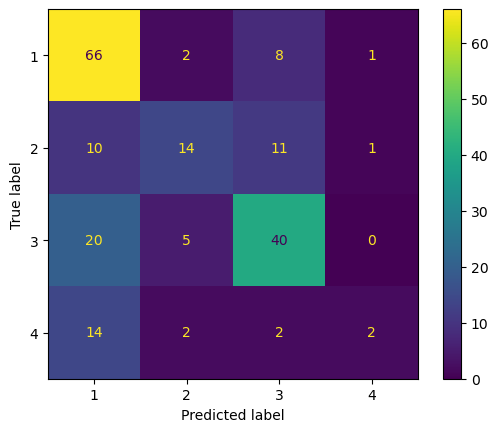

In [31]:
plot_confusion_matrix(rf_cls, X_test_scale, y_test);

# XGBoost

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [33]:
mlflow.xgboost.autolog()

xgb_clf = XGBClassifier(n_estimators=100, max_depth=10, random_state=42)

with mlflow.start_run(experiment_id='1'):
    xgb_clf.fit(
        X_train_scale, y_train,
        eval_set=[(X_train_scale, y_train), (X_test_scale, y_test)],
        verbose=True,
        )
    mlflow.log_metric('accuracy', accuracy_score(y_test, xgb_clf.predict(X_test_scale)))

/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.99814	validation_1-mlogloss:1.26899
[1]	validation_0-mlogloss:0.75351	validation_1-mlogloss:1.18340
[2]	validation_0-mlogloss:0.56885	validation_1-mlogloss:1.11964
[3]	validation_0-mlogloss:0.44007	validation_1-mlogloss:1.08808
[4]	validation_0-mlogloss:0.34640	validation_1-mlogloss:1.07604
[5]	validation_0-mlogloss:0.27266	validation_1-mlogloss:1.06556
[6]	validation_0-mlogloss:0.21730	validation_1-mlogloss:1.05620
[7]	validation_0-mlogloss:0.17547	validation_1-mlogloss:1.06103
[8]	validation_0-mlogloss:0.14323	validation_1-mlogloss:1.05296
[9]	validation_0-mlogloss:0.11881	validation_1-mlogloss:1.05094
[10]	validation_0-mlogloss:0.09973	validat

In [43]:
valid_model(xgb_clf, X_test_scale, y_test)

Accuracy: 0.6313131313131313
Precision: 0.6384728569639552
Recall: 0.6313131313131313
F1: 0.6185361571970195


/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


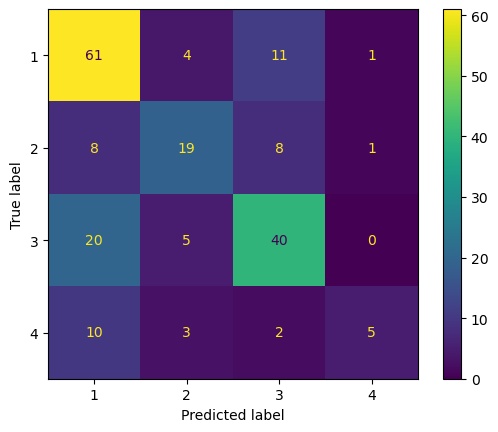

In [44]:
plot_confusion_matrix(xgb_clf, X_test_scale, y_test);

# LightGBM

In [45]:
from lightgbm import LGBMClassifier

In [ ]:
mlflow.lightgbm.autolog()

lgbm_clf = LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)

with mlflow.start_run(experiment_id='1'):
    lgbm_clf.fit(X_train_scale, y_train, eval_set=[(X_train_scale, y_train), (X_test_scale, y_test)], verbose=True)

In [47]:
valid_model(lgbm_clf, X_test_scale, y_test)

Accuracy: 0.6565656565656566
Precision: 0.6599178538122431
Recall: 0.6565656565656566
F1: 0.6418381481215615


/Users/namirinz/opt/anaconda3/envs/geography/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


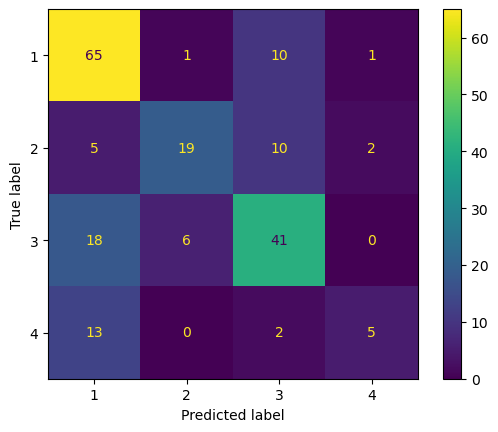

In [48]:
plot_confusion_matrix(lgbm_clf, X_test_scale, y_test);